Auto Keras with Untokenizeddata

In [ ]:
!pip install autokeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.5 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-k

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import autokeras as ak
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Load the new dataset
data = pd.read_csv('/content/Cleaned_data_without_tokenized.csv')

# Preprocess the dataset
data['Cleaned_Resume'] = data['Cleaned_Resume'].fillna("").astype(str)
data['Cleaned_Job_Description'] = data['Cleaned_Job_Description'].fillna("").astype(str)
data['Cleaned_Skills'] = data['Cleaned_Skills'].fillna("").astype(str)
data['Experience'] = data['Experience'].fillna(0)
data['Resume_Score'] = data['Resume_Score'].fillna(data['Resume_Score'].mean())
data['Qualifications'] = data['Qualifications'].fillna("Unknown").astype(str)

# Encode 'Qualifications' as a numeric feature
qual_encoder = LabelEncoder()
data['Qualifications_Encoded'] = qual_encoder.fit_transform(data['Qualifications'])

# Combine primary text fields for embeddings
X_main_text = (
    data['Cleaned_Resume'] + " " +
    data['Cleaned_Job_Description'] + " " +
    data['Cleaned_Skills']
)
X_numeric = data[['Experience', 'Qualifications_Encoded']]
y = data['Resume_Score'].to_numpy()

# Scale numeric features
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Split data into training and test sets
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_main_text, X_numeric_scaled, y, test_size=0.2, random_state=42
)

# Load BERT layer for embeddings
bert_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)

# Convert text data to BERT embeddings
def embed_text(texts):
    embeddings = bert_layer(tf.convert_to_tensor(texts))
    return embeddings.numpy()

X_train_text_embedded = embed_text(X_train_text.tolist())
X_test_text_embedded = embed_text(X_test_text.tolist())

# Prepare data for AutoKeras
X_train_dict = {'text_input': X_train_text_embedded, 'numeric_input': X_train_num}
X_test_dict = {'text_input': X_test_text_embedded, 'numeric_input': X_test_num}

# Define AutoKeras model
input_text = ak.Input(shape=(X_train_text_embedded.shape[1],), name='text_input')
input_numeric = ak.Input(shape=(X_train_num.shape[1],), name='numeric_input')

auto_model = ak.AutoModel(
    inputs=[input_text, input_numeric],
    outputs=ak.RegressionHead(),
    max_trials=30,  # Adjust max_trials based on computational resources
    overwrite=True
)

# Train the AutoKeras model
auto_model.fit(X_train_dict, y_train, epochs=25, validation_split=0.1)

# Predict with AutoKeras model and evaluate
y_pred_autokeras = auto_model.predict(X_test_dict).flatten()
r2_score_autokeras = r2_score(y_test, y_pred_autokeras)
print("AutoKeras Model R^2 Score:", r2_score_autokeras)

# Export the best model from AutoKeras for further use
best_model = auto_model.export_model()
best_model.summary()


Trial 30 Complete [00h 00m 10s]
val_loss: 136.54937744140625

Best val_loss So Far: 77.94519805908203
Total elapsed time: 00h 04m 11s
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3197.8242 - mean_squared_error: 3197.8242
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3098.3704 - mean_squared_error: 3098.3704
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2977.2993 - mean_squared_error: 2977.2993
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2810.1650 - mean_squared_error: 2810.1650
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2565.2612 - mean_squared_error: 2565.2612
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2221.0432 - mean_squared_error: 2221.0432
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1821.8109 - mean_squared_error: 1821.8109
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1324.3311 - mean_squared_error: 1324.3311
Epoch 9/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 866.928

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
AutoKeras Model R^2 Score: 0.14528852701187134


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_to_float32_1         │ (None, 512)            │              0 │ input_layer_1[0][0]    │
│ (CastToFloat32)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │         16,416 │ cast_to_float32_1[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 2)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 2)              │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_to_float32           │ (None, 2)              │              0 │ cast[0][0]             │
│ (CastToFloat32)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          1,056 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1024)           │          3,072 │ cast_to_float32[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 32)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 1024)           │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1056)           │              0 │ re_lu[0][0],           │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1056)           │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ regression_head_1 (Dense) │ (None, 1)              │          1,057 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,601 (84.38 KB)

 Trainable params: 21,601 (84.38 KB)

 Non-trainable params: 0 (0.00 B)

Auto keras withuntokenized+feature enginerring data

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import autokeras as ak
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load the new dataset
data = pd.read_csv('/content/Cleaned_data_without_tokenized.csv')

# Preprocess the dataset
data['Cleaned_Resume'] = data['Cleaned_Resume'].fillna("").astype(str)
data['Cleaned_Job_Description'] = data['Cleaned_Job_Description'].fillna("").astype(str)
data['Cleaned_Skills'] = data['Cleaned_Skills'].fillna("").astype(str)
data['Experience'] = data['Experience'].fillna(0)
data['Resume_Score'] = data['Resume_Score'].fillna(data['Resume_Score'].mean())
data['Qualifications'] = data['Qualifications'].fillna("Unknown").astype(str)

# Encode 'Qualifications' as a numeric feature
qual_encoder = LabelEncoder()
data['Qualifications_Encoded'] = qual_encoder.fit_transform(data['Qualifications'])

# Interaction features
data['Experience_Qualifications'] = data['Experience'] * data['Qualifications_Encoded']

# Normalize the target variable
scaler_target = StandardScaler()
data['Resume_Score_Scaled'] = scaler_target.fit_transform(data[['Resume_Score']])

# Combine primary text fields for embeddings
X_main_text = (
    data['Cleaned_Resume'] + " " +
    data['Cleaned_Job_Description'] + " " +
    data['Cleaned_Skills']
)
X_numeric = data[['Experience', 'Qualifications_Encoded', 'Experience_Qualifications']]
y = data['Resume_Score_Scaled'].to_numpy()

# Scale numeric features
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Split data into training and test sets
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_main_text, X_numeric_scaled, y, test_size=0.2, random_state=42
)


Trial 50 Complete [00h 00m 11s]
val_loss: 0.9704431891441345

Best val_loss So Far: 0.3065098226070404
Total elapsed time: 00h 06m 32s
Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1026 - mean_squared_error: 1.1026
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9207 - mean_squared_error: 0.9207
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7585 - mean_squared_error: 0.7585
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6745 - mean_squared_error: 0.6745
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6385 - mean_squared_error: 0.6385
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5998 - mean_squared_error: 0.5998
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5505 - mean_squared_error: 0.5505
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4910 - mean_squared_error: 0.4910
Epoch 9/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4722 - mean_squared_error: 0.4722
Epoch 10/30
13/13 ━

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
AutoKeras Model R^2 Score: 0.20519449989262073
AutoKeras Model Mean Squared Error: 0.8362667273720098


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_to_float32_1         │ (None, 512)            │              0 │ input_layer_1[0][0]    │
│ (CastToFloat32)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ cast_to_float32_1[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 3)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 3)              │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_to_float32           │ (None, 3)              │              0 │ cast[0][0]             │
│ (CastToFloat32)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │         16,448 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │            128 │ cast_to_float32[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 32)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 96)             │              0 │ re_lu[0][0],           │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ regression_head_1 (Dense) │ (None, 1)              │             97 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 148,001 (578.13 KB)

 Trainable params: 148,001 (578.13 KB)

 Non-trainable params: 0 (0.00 B)

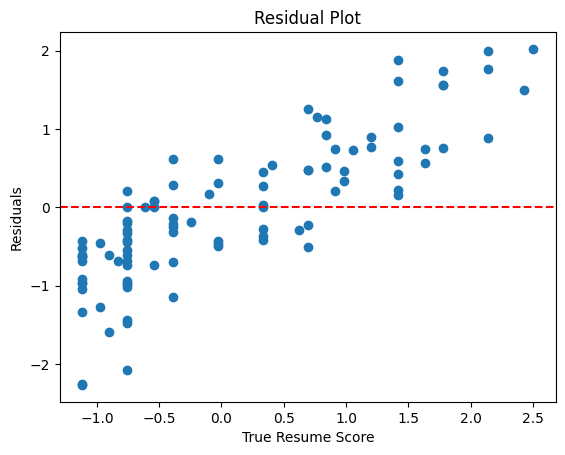

In [ ]:
# Load BERT layer for embeddings
bert_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)

# Convert text data to BERT embeddings
def embed_text(texts):
    embeddings = bert_layer(tf.convert_to_tensor(texts))
    return embeddings.numpy()

X_train_text_embedded = embed_text(X_train_text.tolist())
X_test_text_embedded = embed_text(X_test_text.tolist())

# Prepare data for AutoKeras
X_train_dict = {'text_input': X_train_text_embedded, 'numeric_input': X_train_num}
X_test_dict = {'text_input': X_test_text_embedded, 'numeric_input': X_test_num}

# Define AutoKeras model
input_text = ak.Input(shape=(X_train_text_embedded.shape[1],), name='text_input')
input_numeric = ak.Input(shape=(X_train_num.shape[1],), name='numeric_input')

auto_model = ak.AutoModel(
    inputs=[input_text, input_numeric],
    outputs=ak.RegressionHead(),
    max_trials=50,  # Increased max_trials for better architecture search
    overwrite=True
)

# Train the AutoKeras model
auto_model.fit(X_train_dict, y_train, epochs=30, validation_split=0.1)

# Predict with AutoKeras model and evaluate
y_pred_autokeras = auto_model.predict(X_test_dict).flatten()
r2_score_autokeras = r2_score(y_test, y_pred_autokeras)
mse_autokeras = mean_squared_error(y_test, y_pred_autokeras)

print("AutoKeras Model R^2 Score:", r2_score_autokeras)
print("AutoKeras Model Mean Squared Error:", mse_autokeras)

# Export the best model from AutoKeras for further tuning
best_model = auto_model.export_model()
best_model.summary()

# Plot Residuals
residuals = y_test - y_pred_autokeras
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('True Resume Score')
plt.ylabel('Residuals')
plt.show()
